# Fuzzy Modelling and Control

## Import libraries

In [1]:
# This ensures all modules are re-imported when import is called. This is useful for easier development and debugging.
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math


In [3]:
import control
from control.matlab import *

In [4]:
from modelling.signal_generation import drbsgen
from modelling.simulation import Helicrane

## Get Static Characteristics

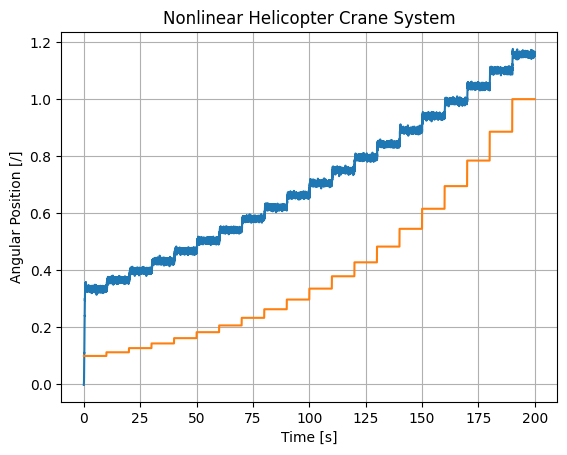

In [5]:
# Define initial conditions and time span
x0 = [0.0, 0.0]  # Initial angular position and velocity
time_step = 10.0
Tp = 1 # Estimated time constant... in seconds

Ts = 0.01

input_steps = np.logspace(0, 1, num=20) * 1

nr_steps = len(input_steps)
total_time = nr_steps*time_step
t = np.arange(0, total_time, Ts)

u = np.repeat(input_steps, int(time_step/Ts))
u_steps = u
t_steps = t
# Simulate the helicrane system
helicrane = Helicrane()
x = helicrane.simulate(x0, u, t) 

# Extract the angular position from the states
theta = x[:, 0]
y_steps = theta
theta  += np.random.normal(0, 0.005, size=theta.shape)  # Add some noise

# Plot the results
plt.plot(t, theta)
plt.plot(t, u/10)
plt.xlabel(r'Time [s]')
plt.ylabel(r'Angular Position [/]')
plt.title('Nonlinear Helicopter Crane System')
plt.grid(True)
plt.show()



In [6]:
Yss = []
Uss = []
for i in range(0, nr_steps):
    Yss.append(theta[int((i)*time_step/Ts+0.8*time_step/Ts):(i+1)*int((time_step)/Ts)].mean())
    Uss.append(input_steps[i])

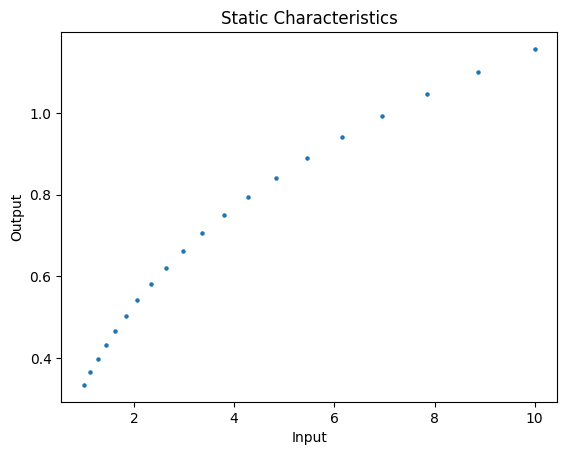

In [7]:
plt.scatter(Uss,Yss, s=5)
plt.xlabel(r'Input')
plt.ylabel(r'Output')
plt.title(r'Static Characteristics')
plt.show()


## Fuzzy Clustering

In [8]:
from modelling.utils import plot_cov_ellipse
from modelling.gk import GK

In [9]:
X = np.vstack([Uss,Yss]).T

In [10]:
# If fails, retry due to singularity...
for i in range(10):
    try:
        gk = GK(n_clusters=5)
        res = gk.fit(X)
        break
    except:
        pass
gk.V

array([[5.8548613 , 0.91656508],
       [3.60649156, 0.72860593],
       [8.90259655, 1.10052098],
       [1.2901387 , 0.3989546 ],
       [2.21961616, 0.56189924]])

Text(0.5, 1.0, 'Static Characteristics')

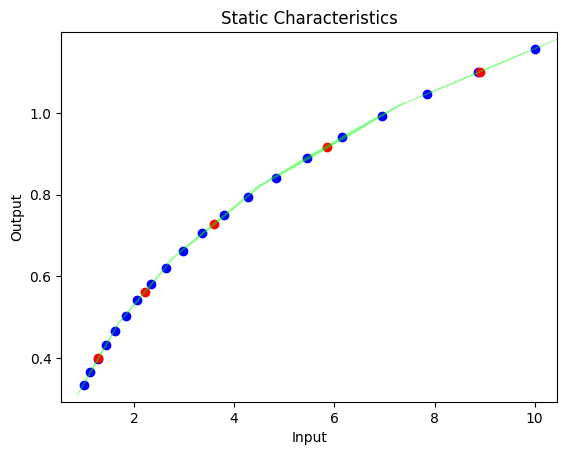

In [11]:

plt.figure()
plt.scatter(X[:,0], X[:,1], color='b')
plt.scatter(gk.V[:,0], gk.V[:,1], color='r')

for i in range(gk.c):
    pos = gk.V[i]
    plot_cov_ellipse(gk.A[i,:], pos, facecolor=(0, 1, 0, 0.5))

plt.xlabel(r'Input')
plt.ylabel(r'Output')
plt.title(r'Static Characteristics')

### Membership funcitons

In [12]:
beta = np.ones([X.shape[0], gk.c])
mi = 1
for i in range(gk.c):
    variances = np.diag(gk.A[i])
    for j in range(len(variances)):
        vari = variances[j]
        v_l = gk.V[i,j]
        x_l = X[:,j]
        beta[:,i] = beta[:,i]*np.exp(-0.5*(v_l-x_l)**2/(mi*vari))
beta = beta/np.sum(beta, axis=1).reshape(-1,1)


Text(0, 0.5, '$\\mu [/]$')

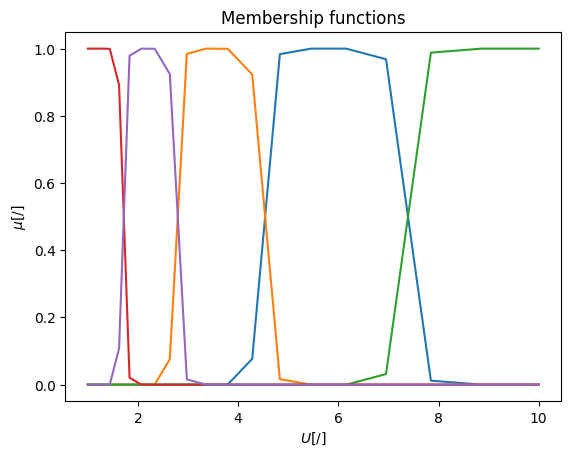

In [13]:
plt.plot(X[:,0], beta)
plt.title(r"Membership functions")
plt.xlabel(r"$U [/]$")
plt.ylabel(r"$\mu [/]$")

### Local linear models identification

In [14]:
from modelling.model_estimation import estimate_parameters

In [15]:
nr_poles = 2
nr_zeros = 2
dead_time = 0
time_experiment = 50
idx_steadyState = int(5/Ts) #N seconds/Ts
G = list()
for i in range(gk.c):

    eigenvalues, _ = np.linalg.eig(gk.A[i])
    width, height = 2 * 2 * np.sqrt(eigenvalues)
    dU = width # max delta U

    x0 = [0.0, 0.0]  # Initial angular position and velocity
    prbs, time = drbsgen(1/Ts, 1/(2), time_experiment)
    prbs = prbs*dU - dU/2
    
    U_DT = gk.V[i,0]
    
    U = prbs + U_DT
    U[:idx_steadyState] = gk.V[i,0]*np.ones(idx_steadyState)
    U[U<0] = 0

    X = helicrane.simulate(x0, U, time) 
    Y = X[:, 0]
    
    Y_DT = np.mean(Y[int(3*Tp/Ts):idx_steadyState])
    #Y_DT = gk.V[i,1]
    #gk.V[i] = np.array([U_DT, Y_DT])
    print(U_DT, Y_DT)
    
    U = U[idx_steadyState:]
    Y = Y[idx_steadyState:]
    
    u = U - U_DT
    y = Y - Y_DT
    t = time[idx_steadyState:]


    TH = estimate_parameters(u,y, nr_poles=nr_poles, nr_zeros=nr_zeros, dead_time=dead_time)
    _G = control.TransferFunction(TH[nr_poles:], np.concatenate(([1], TH[:nr_poles])), dt=Ts)
    _G.InputDelay = dead_time
    G.append(_G)
gk.V

5.854861297901664 0.9196193199785396
3.6064915555394865 0.7313021579307905
8.90259654722958 1.1023010029678642
1.2901386996874076 0.40158969062724653
2.2196161648905637 0.5641547736835353


array([[5.8548613 , 0.91656508],
       [3.60649156, 0.72860593],
       [8.90259655, 1.10052098],
       [1.2901387 , 0.3989546 ],
       [2.21961616, 0.56189924]])

#### Responses in steady states

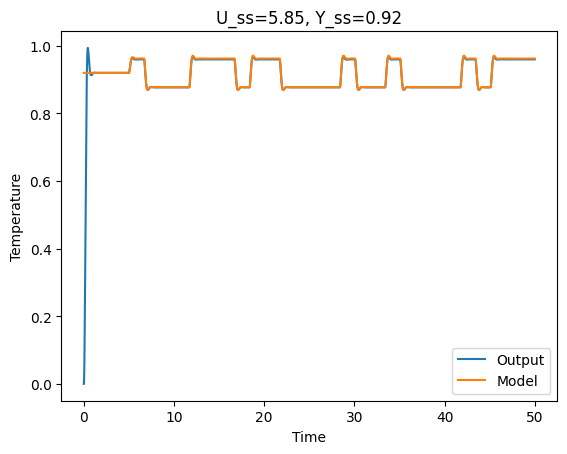

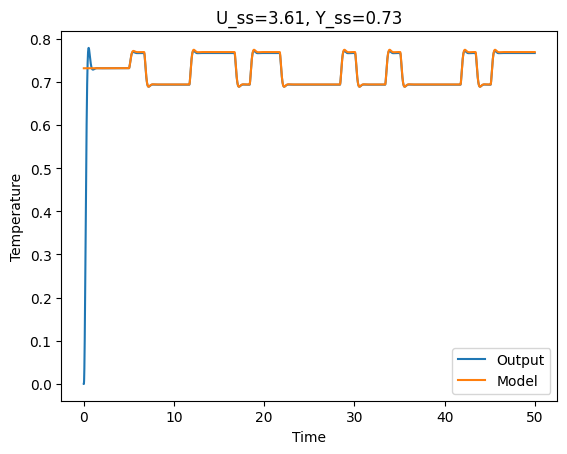

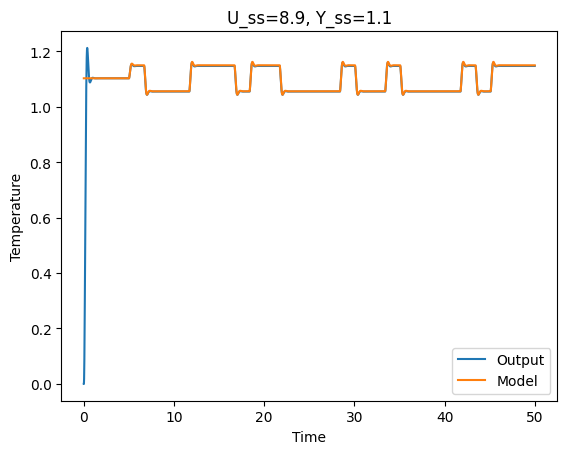

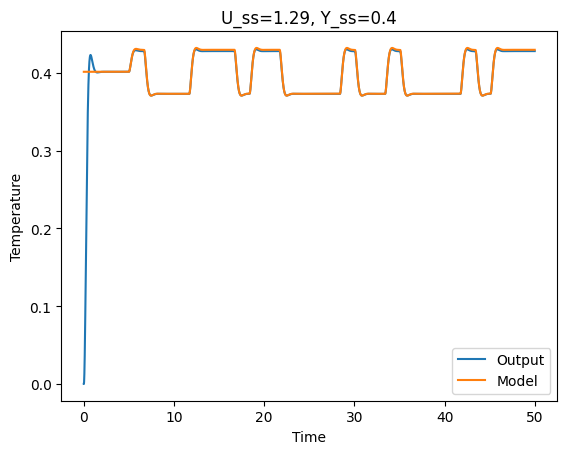

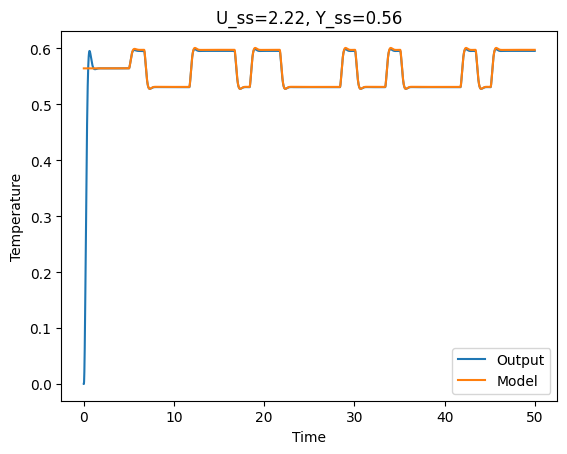

In [16]:
plt.figure()

for ii in range(gk.c):

    dU = gk.V[ii,0]*0.2
    prbs, time = drbsgen(1/Ts, 1/(5), time_experiment)
    prbs = prbs*dU - dU/2
    U = prbs + gk.V[ii,0]
    U[U<0] = 0
    U[:idx_steadyState] = gk.V[ii,0]*np.ones(idx_steadyState)
    u = U - gk.V[ii,0]
    t = np.arange(0,u.shape[0])* Ts
    X = helicrane.simulate(x0, U, time) 
    Y = X[:, 0]
    Y_DT = Y[int(3*Tp/Ts):idx_steadyState].mean()
    ysim = control.forced_response(G[ii], T=t, U=u)[1] + Y_DT
    # Plot the input and output data
    plt.plot(t, Y, label='Output')
    plt.plot(t, ysim, label='Model')
    plt.xlabel('Time')
    plt.ylabel('Temperature')
    plt.title(f"U_ss={round(gk.V[ii,0], 2)}, Y_ss={round(gk.V[ii,1], 2)}")
    plt.legend()
    plt.show()


### Fuzzy model simulation

In [17]:
from modelling.simulation import fuzzy_sim

In [18]:
U = u_steps
t = t_steps

In [19]:
y_model = fuzzy_sim(G, gk, U)

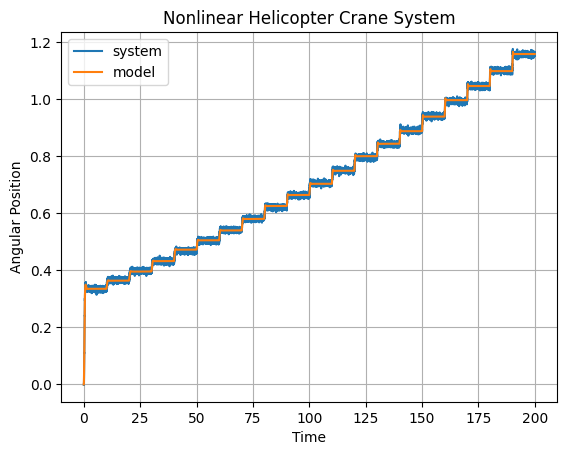

In [20]:
plt.plot(t, y_steps, label='system')
plt.plot(t, y_model, label='model')
plt.xlabel('Time')
plt.ylabel('Angular Position')
plt.title('Nonlinear Helicopter Crane System')
plt.grid(True)
plt.legend()
plt.show()

In [21]:
from modelling.signal_generation import aprbsgen

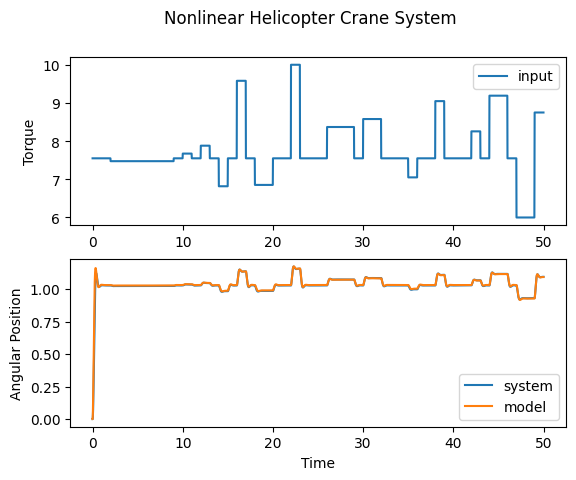

In [22]:
U,t = aprbsgen(1/Ts, 1/(3), time_experiment, min_val=6, max_val=10, seed=1)
y_model = fuzzy_sim(G, gk, U)
Y = helicrane.simulate(x0, U, t) 
Y = Y[:,0]
plt.figure()
plt.suptitle('Nonlinear Helicopter Crane System')

plt.subplot(2,1,1)
plt.plot(t, U, label='input')
plt.ylabel('Torque')
plt.legend()

plt.subplot(2,1,2)
plt.plot(t, Y, label='system')
plt.plot(t, y_model, label='model')
plt.xlabel('Time')
plt.ylabel('Angular Position')
plt.legend()

plt.show()

#### One step ahead prediction

In [23]:
from modelling.simulation import FuzzyModel

In [24]:
model = FuzzyModel(G, gk)

In [25]:
y_model2 = np.zeros_like(t)
for i in range(t.shape[0]):
    y_l = model.step(U[i])
    y_model2[i] = y_l

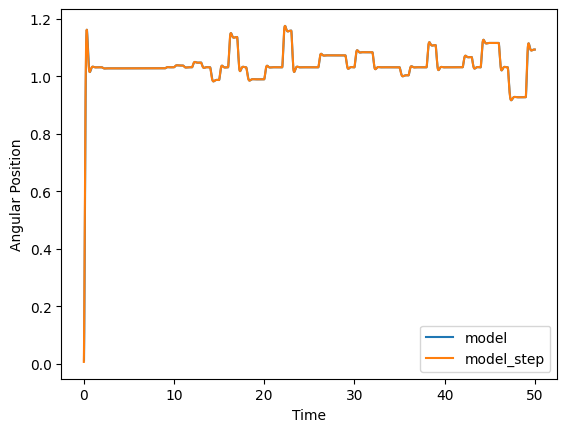

In [26]:
plt.figure()

plt.plot(t[2:], y_model[2:], label='model')
plt.plot(t, y_model2, label='model_step')

plt.xlabel('Time')
plt.ylabel('Angular Position')
plt.legend()

plt.show()

## Predictive Functional Controller

### Convert models into state space representation

In [27]:
from modelling.utils import observable_canonical_form

In [28]:
G_ss = []
for i in range(gk.c):
    num = np.ravel(G[i].num)
    den = np.ravel(G[i].den)
    
    #model_ss_soko = observable_canonical_form(G[i]) # TODO:Somethin is not okay with that form...
    model_ss = {}
    model_ss_soko ,_ = control.observable_form(control.tf2ss(G[i]))

    # model_ss["A"] = model_ss_soko["A"]
    # model_ss["B"] = model_ss_soko["B"]
    # model_ss["C"] = model_ss_soko["C"]
    # model_ss["D"] = model_ss_soko["D"]
    model_ss["A"] = model_ss_soko.A
    model_ss["B"] = model_ss_soko.B
    model_ss["C"] = model_ss_soko.C
    model_ss["D"] = model_ss_soko.D
    model_ss["R"] = np.dot(np.array([[0,0], [sum(den), sum(num)]]), np.array([gk.V[i,1], -gk.V[i,0]]))
    G_ss.append(model_ss)

In [29]:
ref_model_pole = -6.08*3 #((math.log(control.pole(G[0]).real.max()) / Ts)) -- we want to have continious pole more on left side of s-plane

In [30]:
Ar = np.array([np.exp(ref_model_pole*Ts)]) # --> calculate pole in z-plane
Br = np.eye(Ar.shape[0]) - Ar
Cr = np.eye(Ar.shape[0])
Dr = 0
G_ref = control.ss(Ar,Br,Cr,Dr, Ts)

## PFC

In [31]:
from modelling.signal_generation import generate_reference_signal
from modelling.simulation import FuzzyModelSS, ModelSS

## Reference tracking

In [32]:
H = 40 # Prediction horizont
ref_vals = np.linspace(0.6, 1.0, 20)
samples_constant = int(5/Ts)
ref = generate_reference_signal(ref_vals, samples_constant)
N = ref.shape[0]
t = np.arange(0,N)*Ts

In [33]:
model = FuzzyModelSS(G_ss, gk)
ref_model = ModelSS(G_ref)
helicrane.reset_states(np.array([0,0]))

In [34]:
ym = np.zeros_like(t)
u_record = np.zeros_like(t)
ref_record = np.zeros_like(t)
process_record = np.zeros_like(t)
u = np.array([0])
min_sysInput = 0
max_sysInput = 10
max_difference_actuator = 0.1
for i in range(t.shape[0]):
    y_l = model.step(u[0])
    ym[i] = y_l
    
    yp = helicrane.step(u[0])[0]

    ref_l = ref_model.step(ref[i])

    # Calculate G0.
    G0 = model.Cm@(model.Am**H - np.eye(model.Am.shape[0]))
    G0 = G0@np.linalg.inv(model.Am - np.eye(model.Am.shape[0]))
    G0 = G0@model.Bm
    # Calculate G.
    Ga = np.linalg.inv(G0) * (np.eye(ref_model.G_ss.A.shape[0]) - ref_model.G_ss.A**H)
    u = Ga@(np.array(ref_l) - np.array(yp)) + np.linalg.inv(G0)@np.array(y_l) - np.linalg.inv(G0)@model.Cm@model.Am**H@model.x_curr - ((1/model.Bm).T@model.Rm)
    u = np.array(u).ravel()
    
    ref_record[i] = ref_l
    process_record[i] = yp

    # actuator limits
    if u[0] - u_record[i-1] > max_difference_actuator: # limit the differential of the control 
        u[0] = u_record[i-1] + max_difference_actuator
    if u[0] - u_record[i-1] < -max_difference_actuator: # limit the differential of the control 
        u[0] = u_record[i-1] - max_difference_actuator
    u_record[i] = u[0]

    if u[0] < min_sysInput:
        u = np.array([min_sysInput])
    if u[0] > max_sysInput:
        u = np.array([max_sysInput])



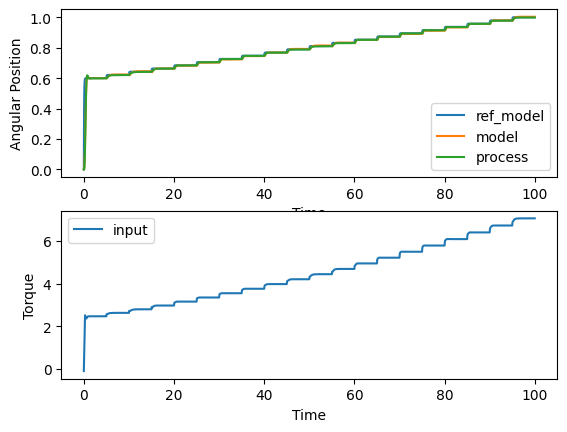

In [35]:

plt.figure()

plt.subplot(2,1,1)
plt.plot(t, ref_record, label='ref_model')
plt.plot(t, ym, label='model')
plt.plot(t, process_record, label='process')
plt.xlabel('Time')
plt.ylabel('Angular Position')
plt.legend()

plt.subplot(2,1,2)
plt.plot(t, u_record, label='input')
plt.xlabel('Time')
plt.ylabel('Torque')
plt.legend()

plt.show()


## Disturbance rejection

In [36]:
H = 40 # Prediction horizont
N = 10000
ref = np.array([0.85]*N)
t = np.arange(0,N)*Ts



disturbance_indices = [0, 3000, 4500, 6000, 8000, N]
disturbance_values  = [0.0, 0.05, -0.1, 0.05, 0.01, 0.0]
disturbance = np.zeros(N)
# Set the values at the disturbance indices to the disturbance values
for i in range(len(disturbance_values)-1):
    if i > 0:
        add_value = disturbance_values[i-1]
    else:
        add_value = 0
    disturbance[disturbance_indices[i]: disturbance_indices[i+1]] = disturbance_values[i] + add_value

In [37]:
model = FuzzyModelSS(G_ss, gk)
ref_model = ModelSS(G_ref)
helicrane.reset_states(np.array([0,0]))

In [38]:
ym = np.zeros_like(t)
u_record = np.zeros_like(t)
ref_record = np.zeros_like(t)
process_record = np.zeros_like(t)
u = np.array([0])
min_sysInput = 0
max_sysInput = 10
max_difference_actuator = 0.1
for i in range(t.shape[0]):
    y_l = model.step(u[0])
    ym[i] = y_l
    
    yp = helicrane.step(u[0])[0] + disturbance[i]

    ref_l = ref_model.step(ref[i])

    # Calculate G0.
    G0 = model.Cm@(model.Am**H - np.eye(model.Am.shape[0]))
    G0 = G0@np.linalg.inv(model.Am - np.eye(model.Am.shape[0]))
    G0 = G0@model.Bm
    # Calculate G.
    Ga = np.linalg.inv(G0) * (np.eye(ref_model.G_ss.A.shape[0]) - ref_model.G_ss.A**H)
    u = Ga@(np.array(ref_l) - np.array(yp)) + np.linalg.inv(G0)@np.array(y_l) - np.linalg.inv(G0)@model.Cm@model.Am**H@model.x_curr - ((1/model.Bm).T@model.Rm)
    u = np.array(u).ravel()
    
    ref_record[i] = ref_l
    process_record[i] = yp

    # actuator limits
    if u[0] - u_record[i-1] > max_difference_actuator: # limit the differential of the control 
        u[0] = u_record[i-1] + max_difference_actuator
    if u[0] - u_record[i-1] < -max_difference_actuator: # limit the differential of the control 
        u[0] = u_record[i-1] - max_difference_actuator
    u_record[i] = u[0]

    if u[0] < min_sysInput:
        u = np.array([min_sysInput])
    if u[0] > max_sysInput:
        u = np.array([max_sysInput])

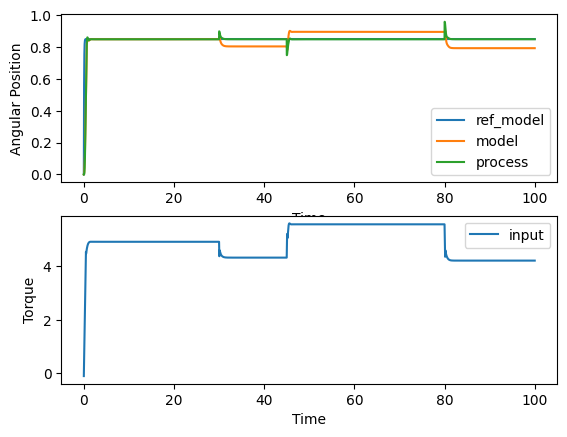

In [39]:
plt.figure()

plt.subplot(2,1,1)
plt.plot(t, ref_record, label='ref_model')
plt.plot(t, ym, label='model')
plt.plot(t, process_record, label='process')
plt.xlabel('Time')
plt.ylabel('Angular Position')
plt.legend()

plt.subplot(2,1,2)
plt.plot(t, u_record, label='input')
plt.xlabel('Time')
plt.ylabel('Torque')
plt.legend()

plt.show()